# Load all the required modules

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import imghdr

2023-03-24 22:18:10.371637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 22:18:10.595936: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 22:18:11.970964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ajdj/miniconda3/lib/:/home/ajdj/miniconda3/lib/:/home/ajdj/miniconda3/lib/:/home

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

2023-03-24 22:18:14.417789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 22:18:14.514409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 22:18:14.514571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Verify all the images are good

In [3]:
dataset_dir=['seg_train','seg_test']
extns=['jpeg','jpg','bmp','png']
bad_dir='bad images'
# Make directory to store bad images
try:
    os.mkdir(bad_dir)
except FileExistsError:
    None
# Iterate through the given directories
for set in dataset_dir:
    for image_class in os.listdir(set):
        for image in os.listdir(os.path.join(set,image_class)):
            image_path=os.path.join(set,image_class,image)
            try:
                img=cv2.imread(image_path) # Check if images load in cv2
                tip=imghdr.what(image_path).lower() # Check if images have acceptable extensions
                if tip not in extns:
                    print(f'Invalid exts: {image_path}')
                    os.rename(image_path,os.path.join(bad_dir,image)) # Move bad images to bad_dir
            except: # Exception handling for cv2 failure
                print(f'Issue with: {image_path}')
                os.rename(image_path,os.path.join(bad_dir,image)) 
# Iterate through the files in prediction directory
for image in os.listdir('seg_pred'):
    image_path=os.path.join('seg_pred',image)
    try:
        img=cv2.imread(image_path) # Check if images load in cv2
        tip=imghdr.what(image_path).lower() # Check if images have acceptable extensions
        if tip not in extns:
            print(f'Invalid exts: {image_path}')
            os.rename(image_path,os.path.join(bad_dir,image)) # Move bad images to bad_dir
    except:  # Exception handling for cv2 failure
        print(f'Issue with: {image_path}')
        os.rename(image_path,os.path.join(bad_dir,image))

# Loading data and normalising 

In [4]:
# Set batch size and load data from test and train directories
batch_size=6
x_train=tf.keras.utils.image_dataset_from_directory('seg_train',image_size=(150,150),batch_size=batch_size)
x_test=tf.keras.utils.image_dataset_from_directory('seg_test',image_size=(150,150),batch_size=batch_size)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


2023-03-24 22:18:31.758620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 22:18:31.759218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 22:18:31.759395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 22:18:31.759476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

In [5]:
# Create a numpy iterator to show a sample of x_train
x_train_iterator=x_train.as_numpy_iterator()
train_batch=x_train_iterator.next()

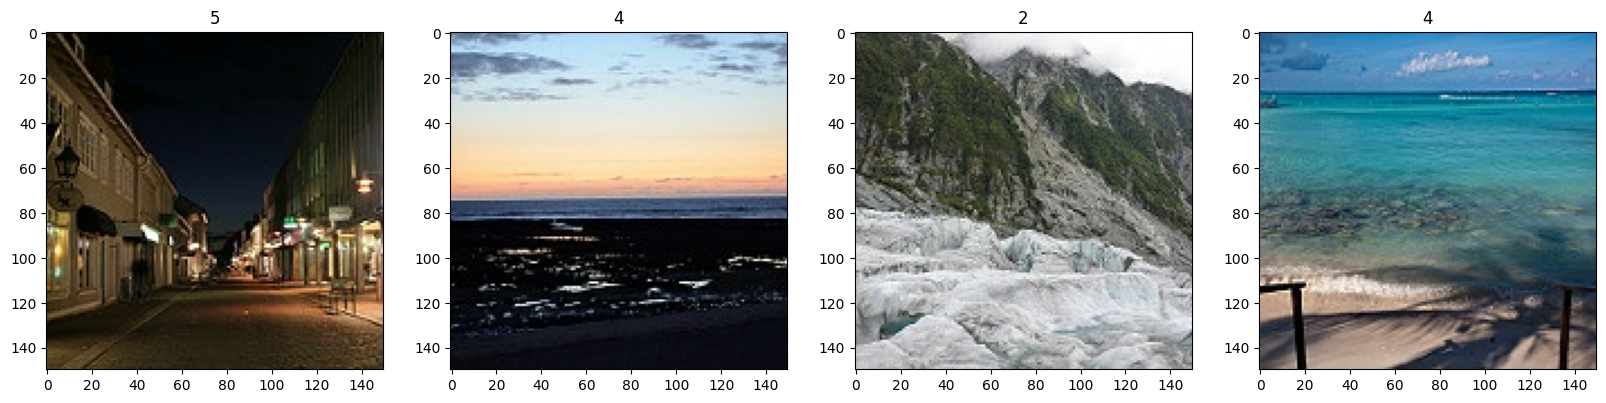

In [6]:
# Showing a sample of the data
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(train_batch[1][idx])

In [7]:
# Normailising x_train and x_test
x_train=x_train.map(lambda x,y: (x/255,y))
x_test=x_test.map(lambda x,y: (x/255,y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
# Define train and test data size
train,test=x_train,x_test
'''train_size=int(len(x_train)*0.8)
test_size=1-train_size
train=x_train.take(train_size)
test=x_train.skip(train_size).take(test_size)
# Note to self, why is taking test=x_test not working'''

'train_size=int(len(x_train)*0.8)\ntest_size=1-train_size\ntrain=x_train.take(train_size)\ntest=x_train.skip(train_size).take(test_size)\n# Note to self, why is taking test=x_test not working'

# Creating and Compiling the model

In [9]:
# Import model layers 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
# Define model as sequential
model = Sequential()
model.add(Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))
model.add(Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))
model.add(Flatten())
model.add(Dense(180,activation='relu'))
model.add(Dense(150,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(6,activation='softmax'))

In [10]:
# Compile module
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Show module summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 200)     5600      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 180)     324180    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 180)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 180)       291780    
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 140)       226940    
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 100)       126100    
                                                        

In [11]:
logdir='logs'
epochs=40
tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)
hist=model.fit(train,epochs=epochs,validation_data=test,callbacks=[tensorboard_callback]) #Train the model

Epoch 1/40


2023-03-24 22:18:35.533168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-24 22:18:39.942910: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-03-24 22:18:40.299544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-24 22:18:40.453276: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1be39640 initialized for platform CUDA (this does not guarantee tha

2339/2339 [==============================] - 216s 87ms/step - loss: 1.1356 - accuracy: 0.5239 - val_loss: 0.9945 - val_accuracy: 0.6130
Epoch 2/40
2339/2339 [==============================] - 203s 87ms/step - loss: 0.8570 - accuracy: 0.6662 - val_loss: 0.7432 - val_accuracy: 0.7177
Epoch 3/40
2339/2339 [==============================] - 203s 87ms/step - loss: 0.7048 - accuracy: 0.7423 - val_loss: 0.6491 - val_accuracy: 0.7663
Epoch 4/40
2339/2339 [==============================] - 202s 87ms/step - loss: 0.6099 - accuracy: 0.7841 - val_loss: 0.6097 - val_accuracy: 0.7920
Epoch 5/40
2339/2339 [==============================] - 203s 87ms/step - loss: 0.5522 - accuracy: 0.8065 - val_loss: 0.5935 - val_accuracy: 0.7943
Epoch 6/40
2339/2339 [==============================] - 203s 87ms/step - loss: 0.5106 - accuracy: 0.8209 - val_loss: 0.5757 - val_accuracy: 0.8093
Epoch 7/40
2339/2339 [==============================] - 202s 87ms/step - loss: 0.4680 - accuracy: 0.8342 - val_loss: 0.5585 - val

# Plotting the Loss and Accuracy 

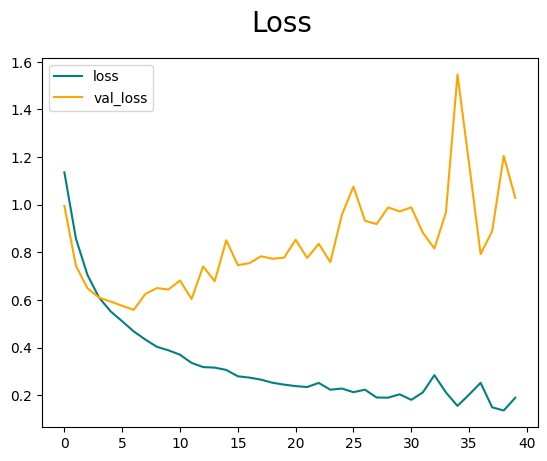

In [12]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

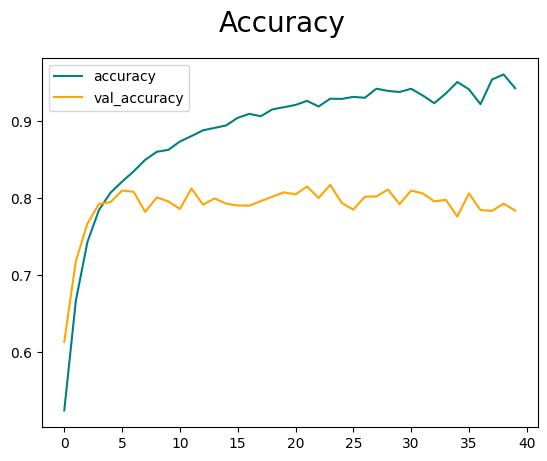

In [13]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Calculate predictions

In [25]:
dir='seg_pred'
yhat=[]
# Predict each image
for img_name in os.listdir(dir):
    img=cv2.imread(os.path.join(dir,img_name))
    resized=tf.image.resize(img,(150,150))
    yhat.append(model.predict(np.expand_dims(resized/255,0)))
preds=[]
# Get max prediction for each image
for i in yhat:
    preds.append(np.argmax(i.reshape(6)))
preds=np.array(preds)
# Save predictions to 'preds.txt'
with open('preds.txt','a') as fl:
    for pred in preds:
        fl.write(f"{pred}\n")

1/1 [==============================] - 0s 18ms/step


# Evaulate the performance


In [21]:
# Import metrics stats
from keras.metrics import Precision, Recall, CategoricalAccuracy

In [22]:
# Define metrics variables
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [26]:
# Iterate over every
for batch in x_test: 
    X, y = batch
    yhat = model.predict(X)[0]
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 14ms/step


In [31]:
# Show Results
print(f'Precision: {pre.result()}')
print(f'Recall: {re.result()}')
print(f'Accuracy: {acc.result()}')

Precision: 0.741631805896759
Recall: 0.13831447064876556
Accuracy: 0.15199999511241913


# Test

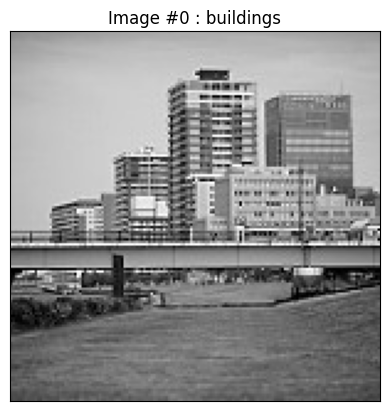

In [32]:
# Show single image
class_names=['buildings','forest','glacier','mountain','sea','street']
i=0
index=preds[i]
img=cv2.imread(os.path.join(dir,os.listdir(dir)[i]))
plt.figure()
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('Image #{} : '.format(i) + class_names[index])
plt.show()


# Save model and reload it

In [34]:
from keras.models import load_model
model.save(os.path.join('models','imageclassifier-self1.h5'))
model = load_model('models/imageclassifier-self1.h5')
names=[i for i in os.listdir(dir)]
class_names=['buildings','forest','glacier','mountain','sea','street']

# Show predictions

In [35]:
# Function to load preds from 'preds.txt'
def load_preds(filename,ls):
    with open(filename,'r') as fl:
        ls=[int(i.strip()) for i in fl.readlines()]
    return ls

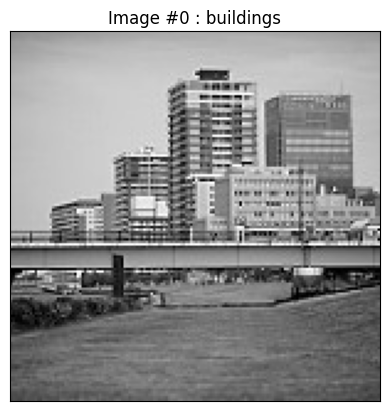

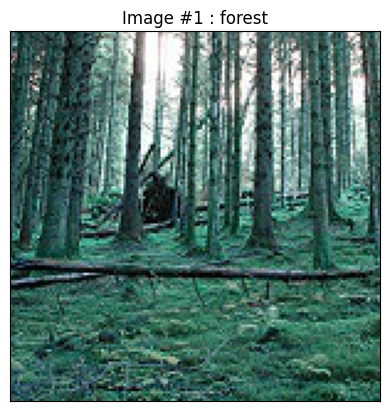

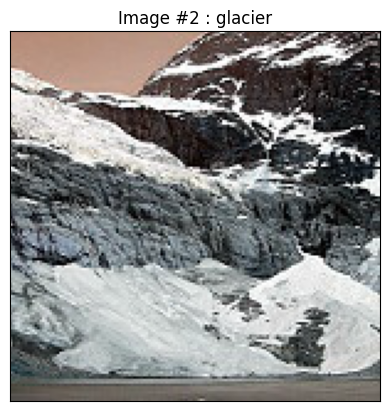

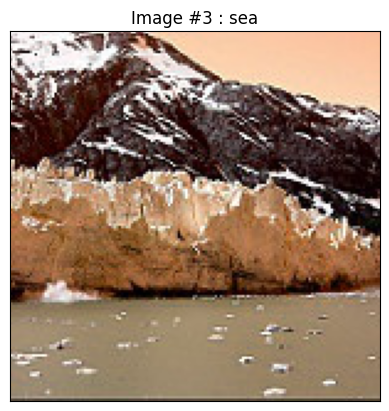

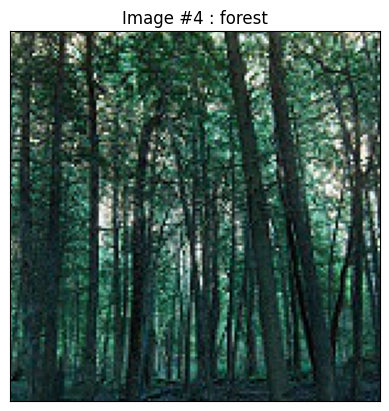

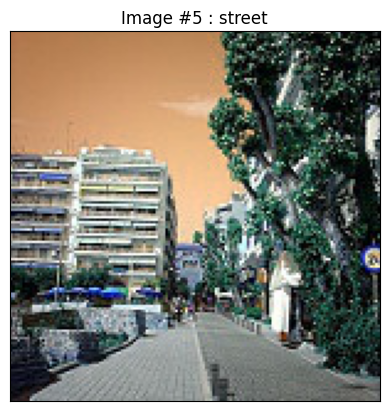

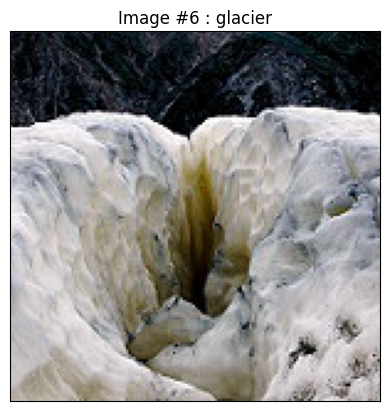

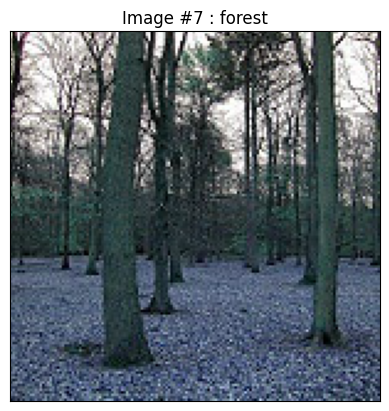

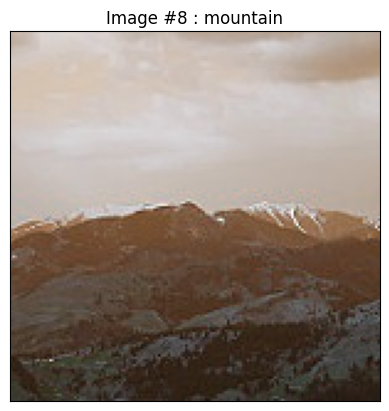

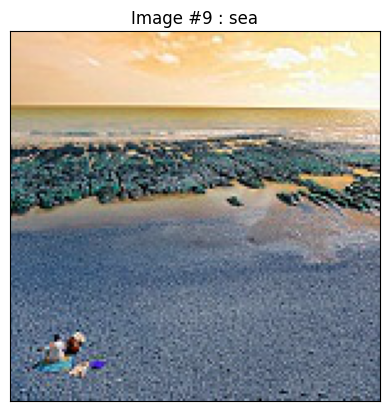

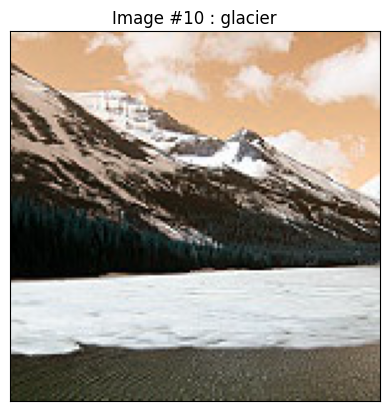

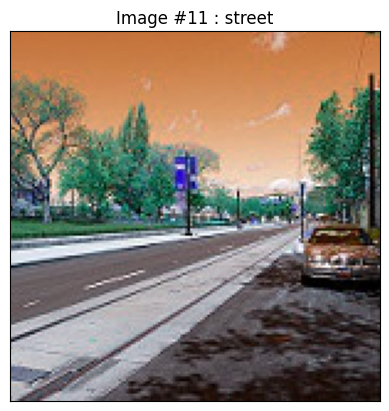

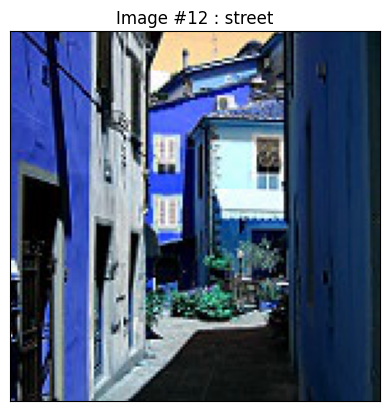

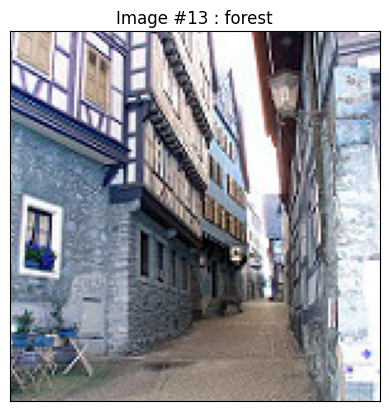

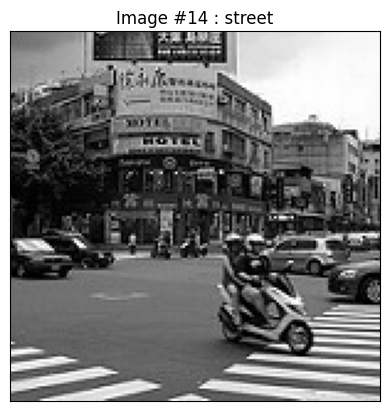

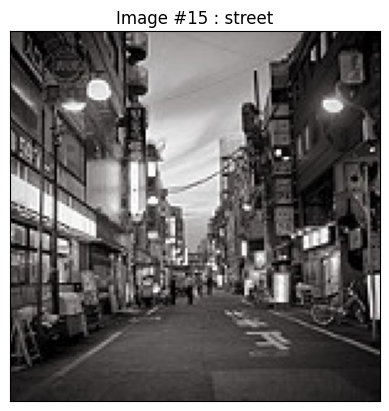

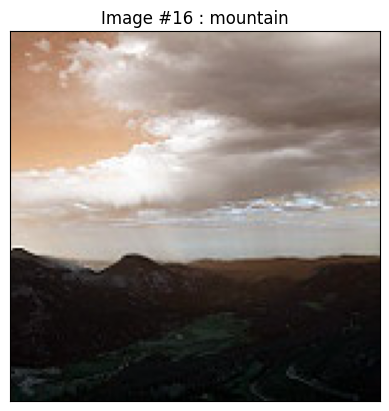

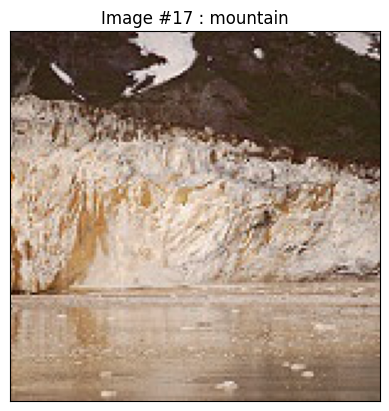

In [37]:
# Show {nums} images
nums=len(os.listdir(dir))//400
for i in range(nums):
    img=cv2.imread(os.path.join(dir,os.listdir(dir)[i]))
    index=preds[i]
    plt.figure()
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(i) + class_names[index])
    plt.show()